# Time series analysis of the data lakes

In [9]:
import glob
import json
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import import_lakes
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import ARDRegression, BayesianRidge
from sklearn.metrics import mean_squared_error


In [2]:
#df = import_lakes.import_lake()
df = import_lakes.import_lake_LeXplore()
df.sort_values(by="M", inplace=True)

In [3]:
df["day"] = df["date"].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

In [4]:
len(df["day"].unique())

202

In [5]:
# create new dataframe with mean values for each day and make day a column
df_day = df.groupby("day").mean()
df_day.reset_index(inplace=True)

/tmp/ipykernel_2276/1668653208.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_day = df.groupby("day").mean()


<Axes: xlabel='day'>

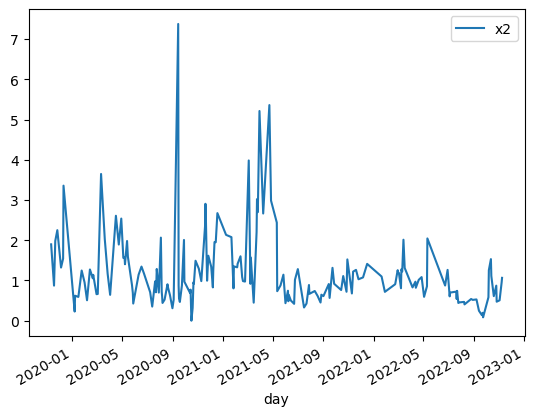

In [6]:
df_day.plot.line(x="day", y="x2")

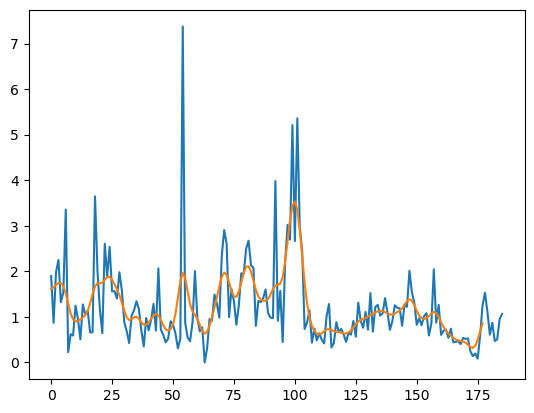

In [7]:
plt.plot(df_day['x2'].values)
plt.plot(gaussian_filter1d(df_day['x2'].values,2))

Text(0, 0.5, 'Temperature (°C)')

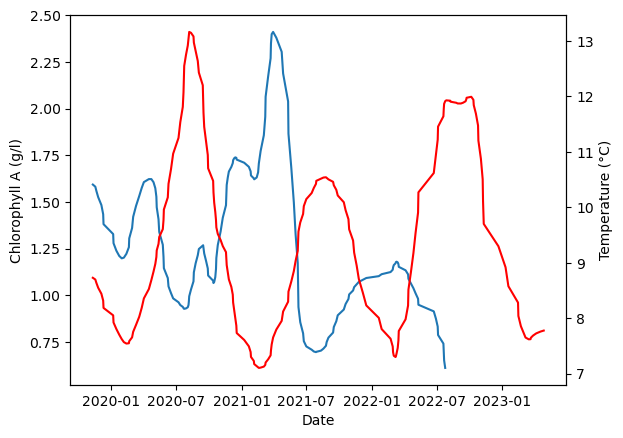

In [20]:
fig, ax = plt.subplots()
#ax.plot(df_day["day"], df_day["x2"], label="x2")
ax.plot(df_day["day"], gaussian_filter1d(df_day["x2"], 5), label="Chlorophyll A")
ax.set_ylabel("Chlorophyll A (g/l)")
ax.set_xlabel("Date")
# twin axis
ax2 = ax.twinx()
ax2.plot(df_day["day"], gaussian_filter1d(df_day["x"], 5), label="temperature", color="red")
ax2.set_ylabel("Temperature (°C)")


In [3]:
df.sort_values(by="x",inplace=True)

In [4]:
day_df = pd.DataFrame([df.to_numpy()[i*8:(i+1)*8].mean(axis=0) for i in range(len(df)//8)],columns=df.columns)

In [5]:
day_df['z6'] = np.maximum(day_df['z6'],3)

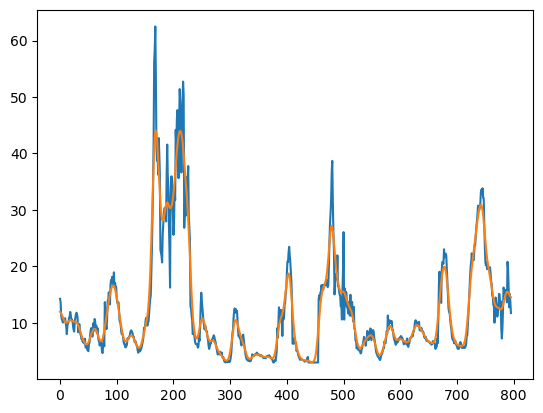

In [6]:
plt.plot(day_df['z6'].values)
plt.plot(gaussian_filter1d(day_df['z6'].values,4))

In [7]:
delta_x = np.diff(day_df['x'].values).mean()
print(delta_x) # in seconds

111592.95597484277


Text(0.5, 1.0, 'Autocorrelation of z6, time step [days] = 1.29')

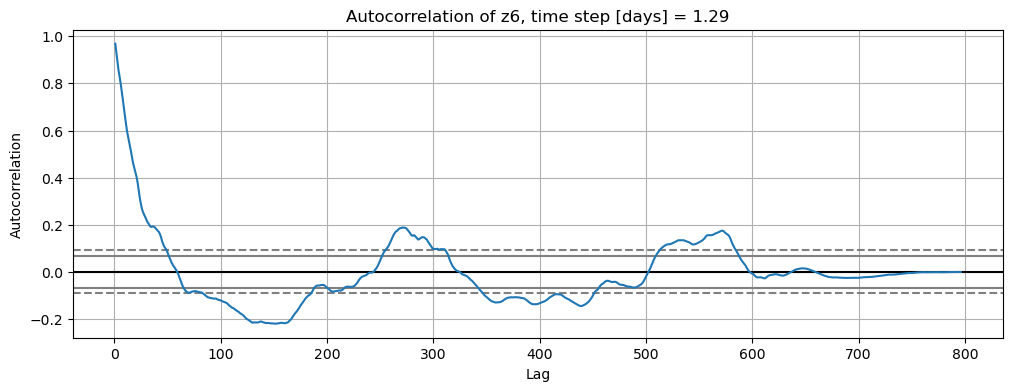

In [8]:
#Calculate autocorrelation
fig, ax = plt.subplots(figsize=(12, 4))
autocorrelation_plot(day_df['z6'],ax=ax)
ax.set_title(f"Autocorrelation of z6, time step [days] = {delta_x/86400:.2f}")

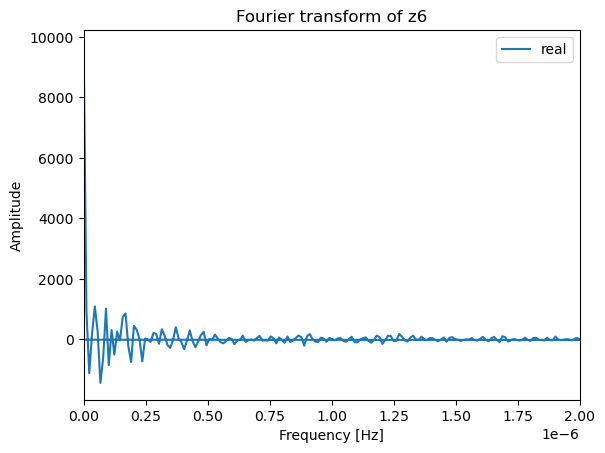

In [14]:
# fourier transform of z6
z6_fft = np.fft.fft(day_df['z6'].values)
z6_fft_freq = np.fft.fftfreq(len(day_df['z6'].values),delta_x)
plt.plot(z6_fft_freq,z6_fft.real)
#plt.plot(z6_fft_freq,z6_fft.imag)
plt.title("Fourier transform of z6")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xlim(0, 2e-6)
plt.legend(["real","imaginary"])
plt.show()

In [7]:
X = np.arange(0,len(day_df['z6'].values))
Y = gaussian_filter1d(day_df['z6'].values,4)

In [8]:
X = np.reshape(X,(len(X),1))

In [13]:
n_train = int(0.8 * len(X))
n_test = int(0.2 * len(Y))
print(n_train, n_test)

636 159


In [14]:
n_predictions = int(len(X)-14)-7
print(n_predictions)

775


In [18]:
ardReg = ARDRegression()
ardReg.set_params(alpha_1=1e-5, alpha_2=1e-5)
bayReg = BayesianRidge()
bayReg.set_params(alpha_1=1e-5,alpha_2=1e-5)
print(ardReg.get_params())

{'alpha_1': 1e-05, 'alpha_2': 1e-05, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'n_iter': 300, 'threshold_lambda': 10000.0, 'tol': 0.001, 'verbose': False}


In [19]:
X_predictions = []
ardReg_predictions = []
bayReg_predictions = []
for i in range(n_predictions):
    t_start = i
    t_end = t_start+14
    X_train, X_test = X[t_start:t_end], X[t_end+7]
    X_test = np.reshape(X_test,(1,1))
    Y_train = Y[t_start:t_end]
    ardReg.fit(X_train,Y_train)
    bayReg.fit(X_train,Y_train)
    X_predictions.append(X_test[0][0])
    ardReg_predictions.append(ardReg.predict(X_test)[0])
    bayReg_predictions.append(bayReg.predict(X_test)[0])    

In [22]:
df_predictions = pd.DataFrame({'X':X_predictions,'ardReg':ardReg_predictions,'bayReg':bayReg_predictions, 'Y':Y[-n_predictions:]})

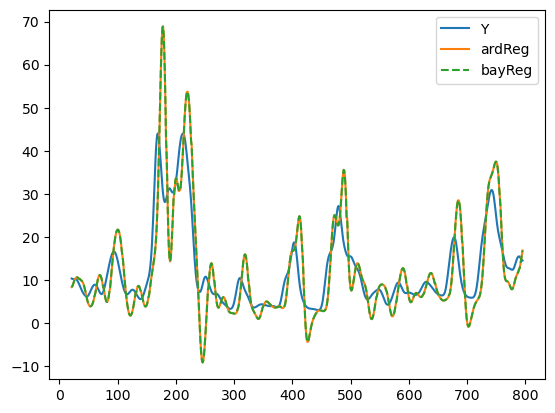

In [24]:
fig, ax = plt.subplots()
ax.plot(df_predictions['X'],df_predictions['Y'],label='Y')
ax.plot(df_predictions['X'],df_predictions['ardReg'],label='ardReg')
ax.plot(df_predictions['X'],df_predictions['bayReg'],label='bayReg', linestyle='--')
ax.legend()
plt.show()

In [71]:
z6data = gaussian_filter1d(day_df['z6'].values,4)

In [72]:
chloro = z6data[:600]
n_steps = 14
X_train, Y_train = [], []
for i in range(n_steps, len(chloro)-6):
    X_train.append(chloro[i-n_steps:i])
    Y_train.append(chloro[i+6])

In [73]:
ardRegression = ARDRegression()
bayRegression = BayesianRidge()
ardRegression.fit(X_train, Y_train)
bayRegression.fit(X_train, Y_train)
prediction_ardRegression = ardRegression.predict(X_train)
prediction_bayRegression = bayRegression.predict(X_train)

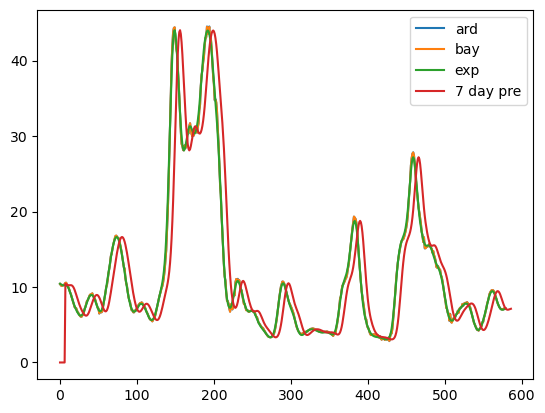

In [74]:
plt.plot(prediction_ardRegression,label="ard")
plt.plot(prediction_bayRegression,label="bay")
plt.plot(np.array(Y_train).tolist(),label='exp')
plt.plot([0 for i in range(7)]+[y for y in np.array(Y_train).tolist()],label='7 day pre')
plt.legend()

In [75]:
chloro = z6data[600:]
n_steps = 14
X_test, Y_test = [], []
for i in range(n_steps, len(chloro)-6):
    X_test.append(chloro[i-n_steps:i])
    Y_test.append(chloro[i+6])

In [76]:
predictions_test_ard = ardRegression.predict(X_test)
predictions_test_bay = bayRegression.predict(X_test)

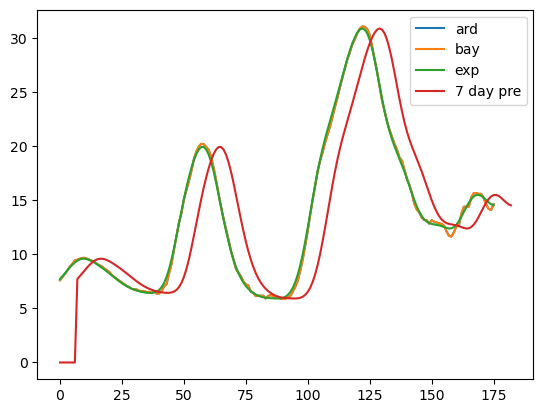

In [77]:
plt.plot(predictions_test_ard,label="ard")
plt.plot(predictions_test_bay,label="bay")
plt.plot(np.array(Y_test).tolist(),label='exp')
plt.plot([0 for i in range(7)]+[y for y in np.array(Y_test).tolist()],label='7 day pre')
plt.legend()

In [79]:
# Calculate RMSE
rmse_ard = np.sqrt(mean_squared_error(Y_test, predictions_test_ard))
rmse_bay = np.sqrt(mean_squared_error(Y_test, predictions_test_bay))
print(f"RMSE ard: {rmse_ard:.4f}, RMSE bay: {rmse_bay:.4f}")

RMSE ard: 0.2432, RMSE bay: 0.2455


In [80]:
day_df.head(2)

,x,z,z1,z2,z3,z4,z5,z6,z7,z8,z9
0,1.593633e+09,9.914375,0.368563,0.250000,70.923749,7.375,7.953188,14.2625,-0.25000,3.46875,-0.36875
1,1.593719e+09,10.816688,0.376937,0.249563,90.485001,9.225,8.042875,13.7750,-0.11875,3.69375,0.29375


## Use pH (z5), Oxigen (z3)and temperature (z)

In [81]:
z6data = gaussian_filter1d(day_df['z6'].values,4)
z5data = gaussian_filter1d(day_df['z5'].values,4)
z3data = gaussian_filter1d(day_df['z3'].values,4)
z_data = gaussian_filter1d(day_df['z'].values,4)

In [82]:
X_train, Y_train = [], []
X_test, Y_test = [], []
n_steps = 14
split = 600
for i in range(n_steps, split-6):
    X_train.append([z6data[i-n_steps:i],z5data[i-n_steps:i],z3data[i-n_steps:i], z_data[i-n_steps:i]])
    Y_train.append(z6data[i+6])
for i in range(split, len(z6data)-6):
    X_test.append([z6data[i-n_steps:i],z5data[i-n_steps:i],z3data[i-n_steps:i], z_data[i-n_steps:i]])
    Y_test.append(z6data[i+6])

In [83]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [84]:
# flatten last two dimensions
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

Text(0.5, 1.0, 'Train')

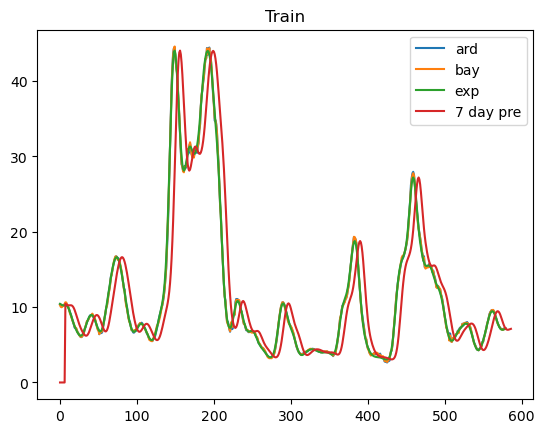

In [85]:
ardRegression = ARDRegression()
bayRegression = BayesianRidge()
ardRegression.fit(X_train, Y_train)
bayRegression.fit(X_train, Y_train)
prediction_ardRegression = ardRegression.predict(X_train)
prediction_bayRegression = bayRegression.predict(X_train)

plt.plot(prediction_ardRegression,label="ard")
plt.plot(prediction_bayRegression,label="bay")
plt.plot(np.array(Y_train).tolist(),label='exp')
plt.plot([0 for i in range(7)]+[y for y in np.array(Y_train).tolist()],label='7 day pre')
plt.legend()
plt.title('Train')

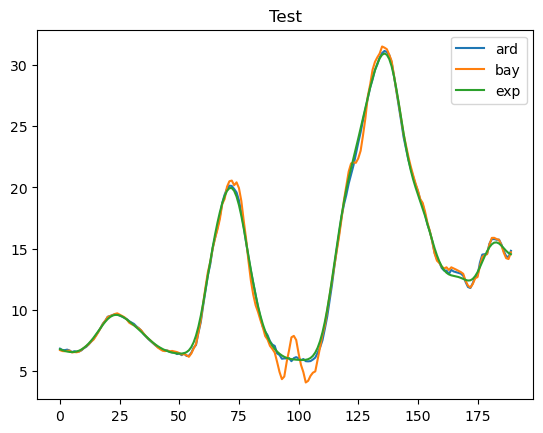

In [86]:
predictions_test_ard = ardRegression.predict(X_test)
predictions_test_bay = bayRegression.predict(X_test)
fig, ax = plt.subplots()
ax.plot(predictions_test_ard,label="ard")
ax.plot(predictions_test_bay,label="bay")
ax.plot(np.array(Y_test).tolist(),label='exp')
#ax.plot([0 for i in range(7)]+[y for y in np.array(Y_test).tolist()],label='7 day pre')
ax.legend()
plt.title('Test')
plt.show()

In [87]:
# rmse for test
rmse_ard = np.sqrt(mean_squared_error(Y_test, predictions_test_ard))
rmse_bay = np.sqrt(mean_squared_error(Y_test, predictions_test_bay))
print('Test RMSE ard: %.3f' % rmse_ard)
print('Test RMSE bay: %.3f' % rmse_bay)

Test RMSE ard: 0.249
Test RMSE bay: 0.595


Iteration 1, loss = 115.28676061
Iteration 2, loss = 73.29967121
Iteration 3, loss = 35.51507707
Iteration 4, loss = 23.10133866
Iteration 5, loss = 17.60737150
Iteration 6, loss = 14.23064118
Iteration 7, loss = 11.93129071
Iteration 8, loss = 10.38812060
Iteration 9, loss = 9.44545961
Iteration 10, loss = 8.71408264
Iteration 11, loss = 8.22350975
Iteration 12, loss = 7.52626238
Iteration 13, loss = 6.92721560
Iteration 14, loss = 6.81832049
Iteration 15, loss = 6.36594834
Iteration 16, loss = 5.75494002
Iteration 17, loss = 5.34945908
Iteration 18, loss = 4.97048155
Iteration 19, loss = 4.63632684
Iteration 20, loss = 4.36627727
Iteration 21, loss = 3.93158358
Iteration 22, loss = 3.67776917
Iteration 23, loss = 3.44686040
Iteration 24, loss = 3.15833322
Iteration 25, loss = 2.92852503
Iteration 26, loss = 2.61542630
Iteration 27, loss = 2.33835649
Iteration 28, loss = 2.08394106
Iteration 29, loss = 1.99421135
Iteration 30, loss = 1.78218812
Iteration 31, loss = 1.65854078
Iteratio

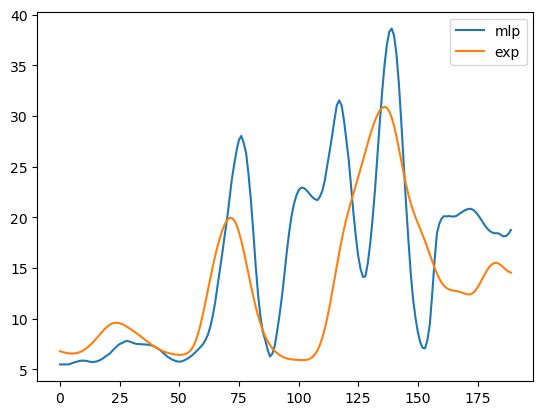

In [88]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPRegressor(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                        solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
mlp.fit(X_train,Y_train)

predictions_test_mlp = mlp.predict(X_test)
plt.plot(predictions_test_mlp,label="mlp")
plt.plot(np.array(Y_test).tolist(),label='exp')
plt.legend()